In [1]:
import torch
import os
import matplotlib.pyplot as plt
from typing import Tuple
from torch.utils.data import DataLoader
import torch.nn as nn
import preprocess_dataset
import field_geometry
import losses 
from main_network import DecompositionNetwork
import network
import train_eval
from tqdm import tqdm
import visualize_primitive
import importlib
from typing import Dict
import random
import numpy
import utils

importlib.reload(preprocess_dataset)


<module 'preprocess_dataset' from '/home/stud/schwemme/Documents/GitHub/Deep-Learning-Network-2D-Natural-Image-Decomposition/preprocess_dataset.py'>

In [2]:
# Hyperparameters:
LEARNING_RATE = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 50
LOAD_MODEL = False
NUM_WORKERS = os.cpu_count()

In [3]:
train_dataset = preprocess_dataset.OxfordIIITPet_Distancefields_train()
test_dataset = preprocess_dataset.OxfordIIITPet_Distancefields_test()

In [4]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

torch.Size([32, 3, 256, 256])


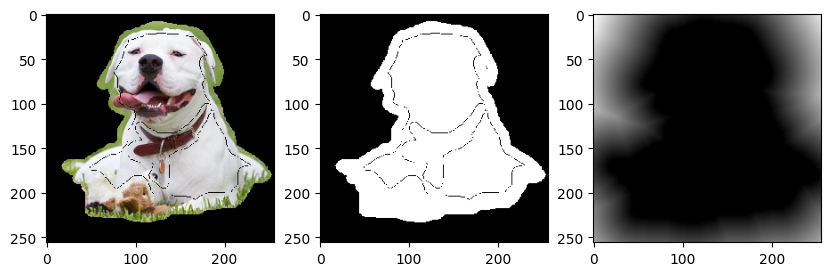

In [5]:
_, ax = plt.subplots(1, 3, figsize=(10, 10))

for x, y in train_dataloader:
    x_masked = preprocess_dataset.mask_rgb_imgs(x, y)
    print(x_masked.shape)
    ax[0].imshow(torch.permute(x_masked[0], (1, 2, 0)))
    ax[1].imshow(torch.squeeze(y[0][0]), cmap="gray")
    ax[2].imshow(torch.squeeze(y[0][1]), cmap="gray")
    break


In [6]:
importlib.reload(train_eval)
image_size = [256, 256]
model = network.Model(
    img_size=image_size,
    conv_channels=(3, 16, 8),
    dense_layers=(2048,),
    num_recs=4,
    num_circs=2
)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


{'Rectangle': 4, 'Circle': 2}


In [7]:
# utils.load_model_param(model, "pet_4recs_2circs_50epoch_2e4lr")

In [8]:
(cov_loss, cons_rect_train_loss, cons_circ_train_loss) = train_eval.train_model(
    NUM_EPOCHS, train_dataloader, train_eval.extract_pet_data, model, NUM_EPOCHS//2, BATCH_SIZE, optim, DEVICE
)

100%|██████████| 115/115 [00:34<00:00,  3.35it/s, loss=all losses: 0.27764 union cov loss: 0.11676 cons_loss_rect 0.13464 cons_loss circle 0.02623]


In [9]:

utils.save_model_param(model, "pet_4recs_2circs_50epoch_2e4lr_16_8_conv")

========== Saving Model Parameters ==========


In [14]:
importlib.reload(visualize_primitive)
importlib.reload(preprocess_dataset)
image_size = [256, 256]

# _, ax = plt.subplots(1,3, figsize=(10,10))
for x, y in train_dataloader:
    y_masked = torch.permute(y, (1, 0, 2, 3, 4))[0]
    x_masked = preprocess_dataset.mask_rgb_imgs(x, y)
    print(x_masked.shape)
    model.cpu().eval()
    with torch.no_grad():
        r, rp, r_rot, c, cp = train_eval.unpack_model_output(
                model.num_dict, 
                model(x_masked.float())
                )
        z_rec = (rp > 0.5)
        z_circ = (cp > 0.5)

    # plot
    for i in range(x.size(0)):
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
        ax1.imshow(x_masked[i].permute(1, 2, 0))
        ax2.imshow(x_masked[i].permute(1, 2, 0))
        ax3.imshow(x_masked[i].permute(1, 2, 0))
        visualize_primitive.plot_rotated_rectangles(ax1, r[i, z_rec[i]], r_rot[i, z_rec[i]], image_size)
        visualize_primitive.plot_rotated_rectangles(ax2, r[i, ~z_rec[i]], r_rot[i, ~z_rec[i]],  image_size)
        visualize_primitive.plot_rotated_rectangles(ax3, r[i], r_rot[i], image_size)
        visualize_primitive.plot_circles(ax1, c[i, z_circ[i]], image_size)
        visualize_primitive.plot_circles(ax2, c[i, ~z_circ[i]], image_size)
        visualize_primitive.plot_circles(ax3, c[i], image_size)
        ax1.set(title="Selected")
        ax2.set(title="Unselected")
        ax3.set(title="Select all")
        plt.savefig(f"pictures/pet_binary_data_rotations_and_circle{i}.png")
        plt.close()
    break




torch.Size([32, 3, 256, 256])


In [11]:
import importlib

importlib.reload(train_eval)    
importlib.reload(preprocess_dataset)



IoU_list = []
for x, y in test_dataloader:
    y_masked = torch.permute(y, (1, 0, 2, 3, 4))[0]
    x_masked = preprocess_dataset.mask_rgb_imgs(x, y)
    model.cpu().eval()
    with torch.no_grad():
        r, rp, r_rot, c, cp = train_eval.unpack_model_output(
                model.num_dict, 
                model(x_masked.float())
                )
        z_rec = (rp > 0.5)
        z_circ = (cp > 0.5)

    IoU_score = train_eval.IoU(r, r_rot, rp, c, cp, 0, y_masked, device="cpu", mode="batch")
    IoU_list.append(IoU_score)

print(sum(IoU_list) / len(IoU_list))


tensor(0.4770)


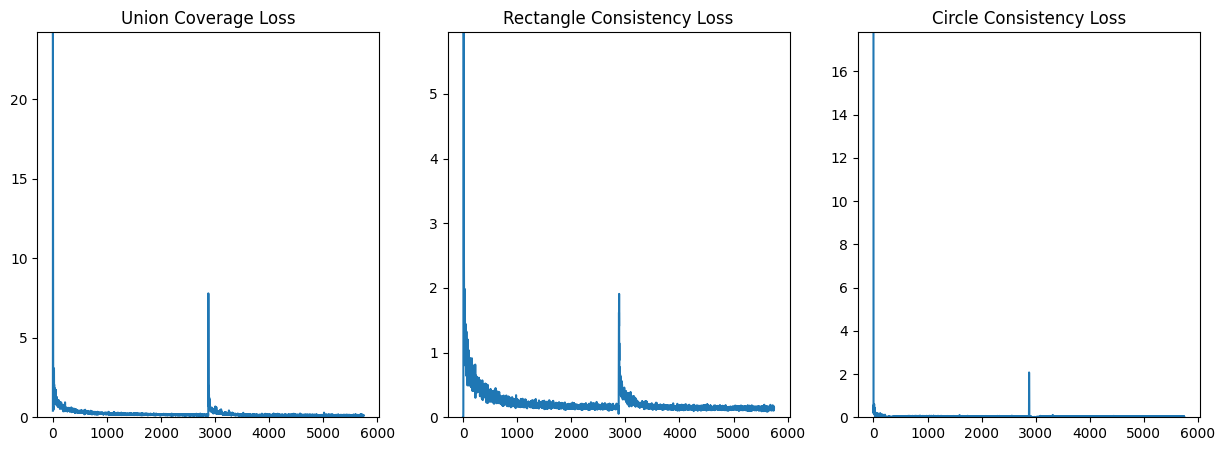

In [12]:
#(cov_loss, cons_rect_train_loss, cons_circ_train_loss)
_, ax = plt.subplots(1, 3, figsize=(15, 5))
cov_loss_stacked = torch.tensor([cov_loss]).flatten()
cons_loss_rect_stacked = torch.tensor([cons_rect_train_loss]).flatten()
cons_loss_circ_stacked = torch.tensor([cons_circ_train_loss]).flatten()


# ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[1].set_ylim([0, cons_loss_rect_stacked.max()])
ax[2].set_ylim([0, cons_loss_circ_stacked.max()])

# ax[3].set_ylim([0, intersect_loss_stacked.max()])
ax[0].set_title("Union Coverage Loss")
ax[0].plot(cov_loss_stacked)
ax[1].set_title("Rectangle Consistency Loss")
ax[1].plot(cons_loss_rect_stacked)
ax[2].set_title("Circle Consistency Loss")
ax[2].plot(cons_loss_circ_stacked)

plt.show()


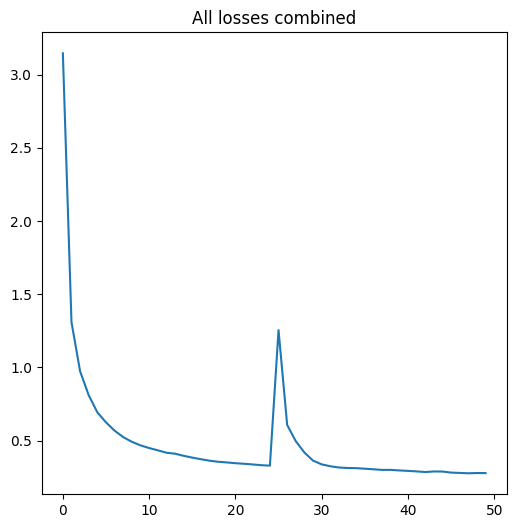

In [13]:
mean_losses = []
for union_cov, rect_cons, circ_cons in zip(cov_loss, cons_rect_train_loss, cons_circ_train_loss):
    mean_losses.append(
        (
            sum(union_cov) / len(union_cov) 
            + sum(rect_cons) / len(rect_cons) 
            + sum(circ_cons) / len(circ_cons)
        )
    )
mean_losses = torch.stack(mean_losses).detach().cpu()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("All losses combined")
ax.plot(mean_losses)
plt.show()
